In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
target = np.array([])
jetList = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
    f.close()
print(target.shape, jetList.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
X_train_full = np.copy(X_train)
X_train = X_train[:,:,[4,6,8,9,11,12,13,15]]
X_val_full = np.copy(X_val)
X_val = X_val[:,:,[4,6,8,9,11,12,13,15]]
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetList, target

(33500, 100, 8) (16500, 100, 8) (33500, 5) (16500, 5)


In [4]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GRU, Dropout, Masking
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [5]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.1

In [6]:
####
inputList = Input(shape=(featureArrayLength))
x = Masking(mask_value=0.0)(inputList)
x = GRU(units=40, activation="tanh", recurrent_activation='sigmoid')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputList, outputs=output)

2023-08-16 23:01:58.354593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 23:01:58.816909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 8)]          0         
                                                                 
 masking (Masking)           (None, 100, 8)            0         
                                                                 
 gru (GRU)                   (None, 40)                6000      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210   

In [8]:
batch_size = 128
n_epochs = 200
# train
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200


2023-08-16 23:02:01.644021: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_41/output/_23'
2023-08-16 23:02:02.456378: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-08-16 23:02:02.565972: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


262/262 - 6s - loss: 1.4782 - val_loss: 1.3679 - lr: 0.0010 - 6s/epoch - 21ms/step
Epoch 2/200
262/262 - 2s - loss: 1.2508 - val_loss: 1.1428 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 3/200
262/262 - 2s - loss: 1.2475 - val_loss: 1.1187 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 4/200
262/262 - 2s - loss: 1.1867 - val_loss: 1.1701 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 5/200
262/262 - 2s - loss: 1.1800 - val_loss: 1.0927 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 6/200
262/262 - 2s - loss: 1.1141 - val_loss: 1.0429 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 7/200
262/262 - 2s - loss: 1.0779 - val_loss: 1.0381 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 8/200
262/262 - 2s - loss: 1.0643 - val_loss: 1.0068 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 9/200
262/262 - 2s - loss: 1.0481 - val_loss: 0.9963 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 10/200
262/262 - 2s - loss: 1.0487 - val_loss: 0.9873 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 11/200
262/262 - 2s - loss: 1.0411 - val_loss: 1.0010 - lr: 0.00

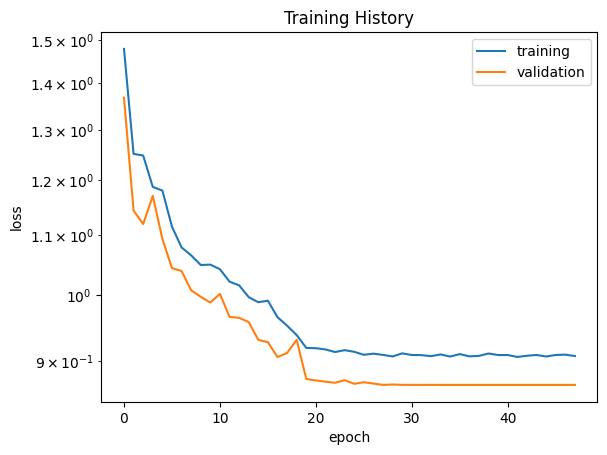

In [9]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

516/516 [==============================] - 2s 2ms/step


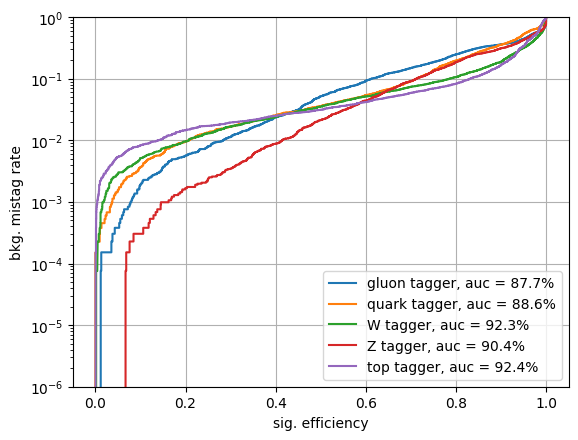

In [10]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
labels = ['gluon', 'quark', 'W', 'Z', 'top']
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

516/516 [==============================] - 1s 1ms/step


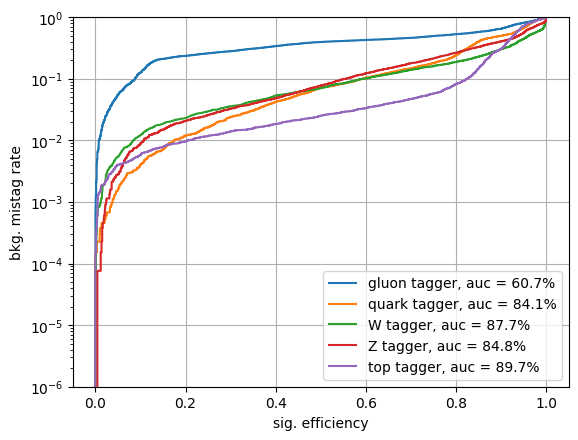

In [11]:
X_val_trim = np.copy(X_val)
X_val_trim[:,30:100,:] = 0

predict_val_10Part = model.predict(X_val_trim)
df = pd.DataFrame()
fprTrim = {}
tprTrim = {}
auc1Trim = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val_10Part[:,i]

        fprTrim[label], tprTrim[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1Trim[label] = auc(fprTrim[label], tprTrim[label])

        plt.plot(tprTrim[label],fprTrim[label],label='%s tagger, auc = %.1f%%'%(label,auc1Trim[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

In [12]:
inputListTrim = Input(shape=(featureArrayLength))
x = Masking(mask_value=0.0)(inputListTrim)
x = GRU(units=40, activation="tanh", recurrent_activation='sigmoid')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(5, activation='relu')(x)
#
outputTrim = Dense(5, activation='softmax')(x)

modelTrim = Model(inputs=inputListTrim, outputs=outputTrim)
modelTrim.compile(loss='categorical_crossentropy', optimizer='adam')

# train
X_train_trim = np.copy(X_train)
X_train_trim[:,30:100,:] = 0
X_val_trim = np.copy(X_val) 
X_val_trim[:,30:100,:] = 0
history = modelTrim.fit(X_train_trim, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val_trim, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
262/262 - 4s - loss: 1.5042 - val_loss: 1.3014 - lr: 0.0010 - 4s/epoch - 17ms/step
Epoch 2/200
262/262 - 1s - loss: 1.2534 - val_loss: 1.1676 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 3/200
262/262 - 1s - loss: 1.1843 - val_loss: 1.1286 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 4/200
262/262 - 1s - loss: 1.1482 - val_loss: 1.0968 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 5/200
262/262 - 1s - loss: 1.1272 - val_loss: 1.0928 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 6/200
262/262 - 1s - loss: 1.1067 - val_loss: 1.0628 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 7/200
262/262 - 1s - loss: 1.0983 - val_loss: 1.0530 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 8/200
262/262 - 1s - loss: 1.0862 - val_loss: 1.0416 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 9/200
262/262 - 1s - loss: 1.0788 - val_loss: 1.0341 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 10/200
262/262 - 1s - loss: 1.0705 - val_loss: 1.0422 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 11/200
262/262 - 1s - loss: 1.0661 - val_loss: 1.013

516/516 [==============================] - 1s 1ms/step


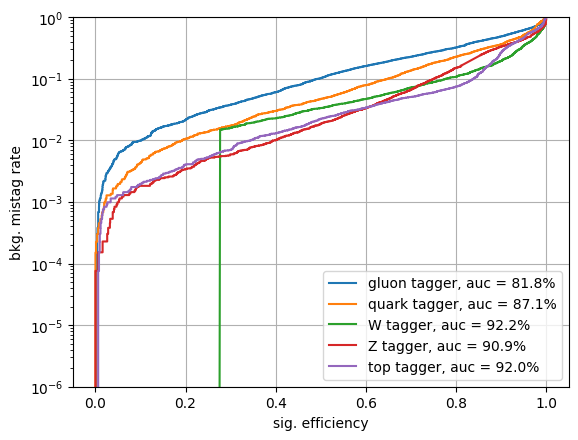

In [13]:
predict_val_TrueTrim = modelTrim.predict(X_val_trim)
df = pd.DataFrame()
fprTrueTrim = {}
tprTrueTrim = {}
auc1TrueTrim = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val_TrueTrim[:,i]

        fprTrueTrim[label], tprTrueTrim[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1TrueTrim[label] = auc(fprTrueTrim[label], tprTrueTrim[label])

        plt.plot(tprTrueTrim[label],fprTrueTrim[label],label='%s tagger, auc = %.1f%%'%(label,auc1TrueTrim[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

516/516 [==============================] - 1s 2ms/step


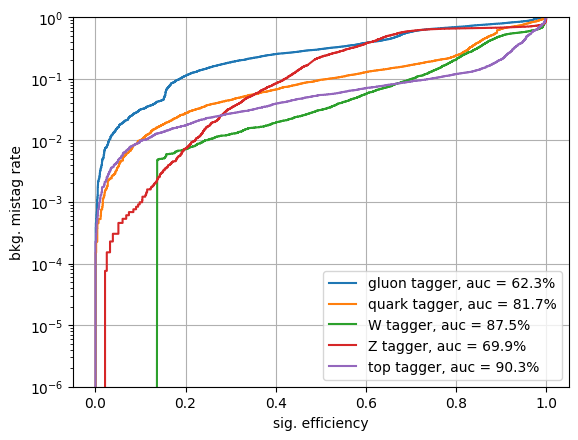

In [14]:
predict_val_ModelTrimFullInput = modelTrim.predict(X_val)
df = pd.DataFrame()
fprModelTrimFullInput = {}
tprModelTrimFullInput = {}
auc1ModelTrimFullInput = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val_ModelTrimFullInput[:,i]

        fprModelTrimFullInput[label], tprModelTrimFullInput[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1ModelTrimFullInput[label] = auc(fprModelTrimFullInput[label], tprModelTrimFullInput[label])

        plt.plot(tprModelTrimFullInput[label],fprModelTrimFullInput[label],label='%s tagger, auc = %.1f%%'%(label,auc1ModelTrimFullInput[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

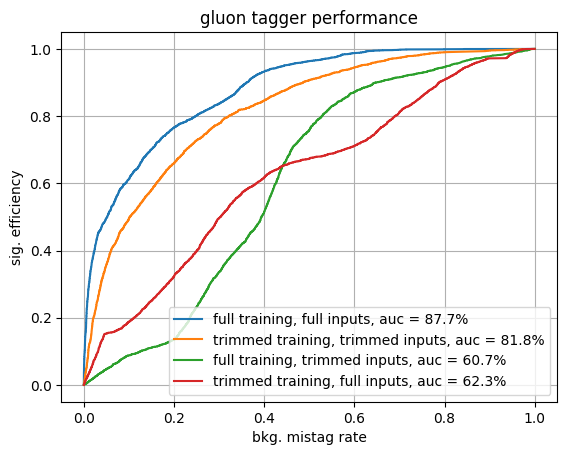

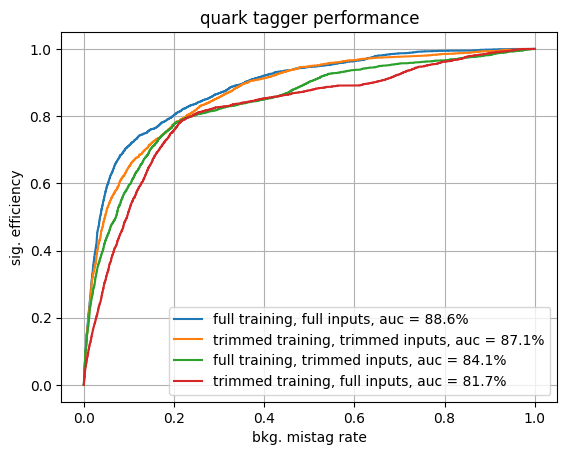

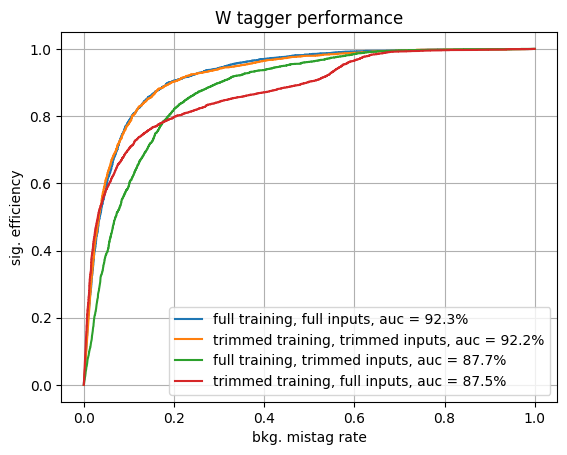

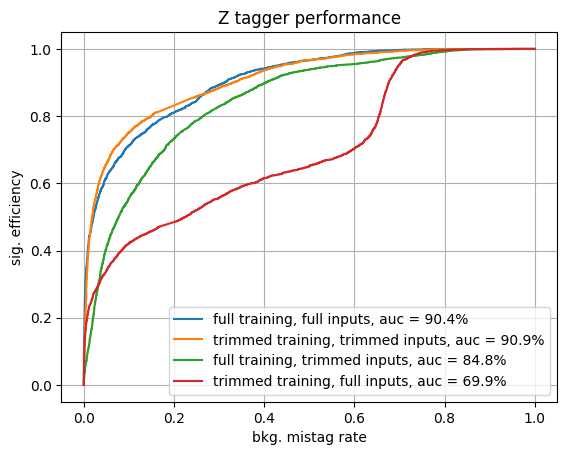

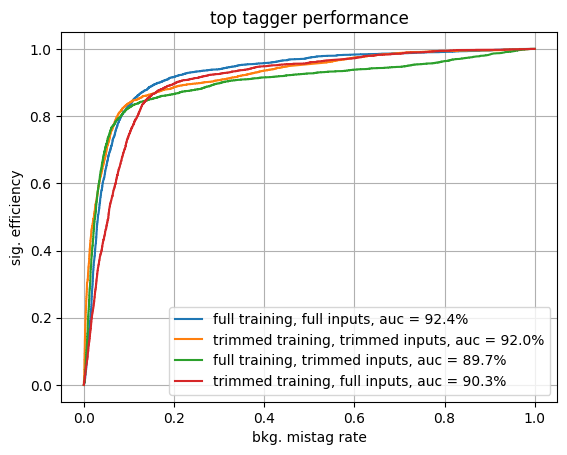

In [15]:
for i, label in enumerate(labels):
  plt.figure()
  plt.plot(fpr[label],tpr[label],label='full training, full inputs, auc = %.1f%%'%(auc1[label]*100.))
  plt.plot(fprTrueTrim[label],tprTrueTrim[label],label='trimmed training, trimmed inputs, auc = %.1f%%'%(auc1TrueTrim[label]*100.))
  plt.plot(fprTrim[label],tprTrim[label],label='full training, trimmed inputs, auc = %.1f%%'%(auc1Trim[label]*100.))
  plt.plot(fprModelTrimFullInput[label],tprModelTrimFullInput[label],label='trimmed training, full inputs, auc = %.1f%%'%(auc1ModelTrimFullInput[label]*100.))
  plt.title("%s tagger performance" %label)
  #plt.semilogy()
  plt.ylabel("sig. efficiency")
  plt.xlabel("bkg. mistag rate")
  #plt.ylim(0.000001,1)
  plt.grid(True)
  plt.legend(loc='lower right')
  plt.savefig("roc_%s.png" % label, dpi=200)
  plt.show()

In [16]:
#Evaluate confusion matrix
from sklearn.metrics import confusion_matrix

def plot_matrix(cm, classes, title):
  plt.figure(figsize = (12,12))
  ax = plt.imshow(cm, cmap="Blues")
  #ax.set(title=title, xlabel="Predicted label", ylabel="True label")

In [17]:
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(predict_val, axis=1),normalize = 'true')
print(cm)
#plot_matrix(cm, labels, title = 'Normalized Confusion Matrix')

[[0.45299401 0.1497006  0.03982036 0.0245509  0.33293413]
 [0.09133271 0.66977322 0.07735322 0.02733768 0.13420317]
 [0.01798232 0.07802499 0.78939348 0.10179823 0.01280098]
 [0.02035319 0.06794373 0.26548937 0.60939838 0.03681532]
 [0.01506478 0.01235312 0.04670081 0.05604098 0.86984031]]


[[0.43143713 0.16197605 0.10628743 0.05988024 0.24041916]
 [0.2009941  0.58310034 0.06834421 0.04380242 0.10375893]
 [0.03444072 0.08046327 0.79701311 0.08107284 0.00701006]
 [0.02663873 0.06674648 0.19784496 0.68961389 0.01915594]
 [0.01596867 0.01205182 0.06598373 0.07562519 0.83037059]]


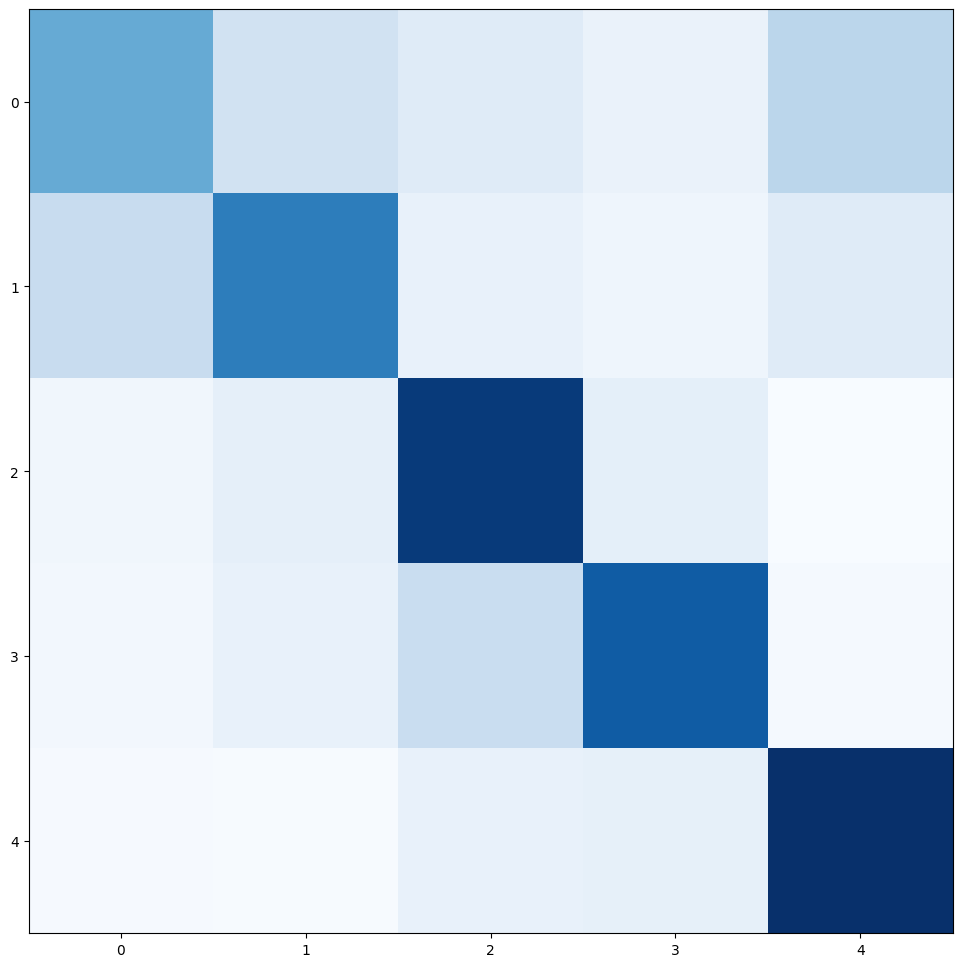

In [18]:
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(predict_val_TrueTrim, axis=1),normalize = 'true')
print(cm)
plot_matrix(cm, labels, title = 'Normalized Confusion Matrix')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


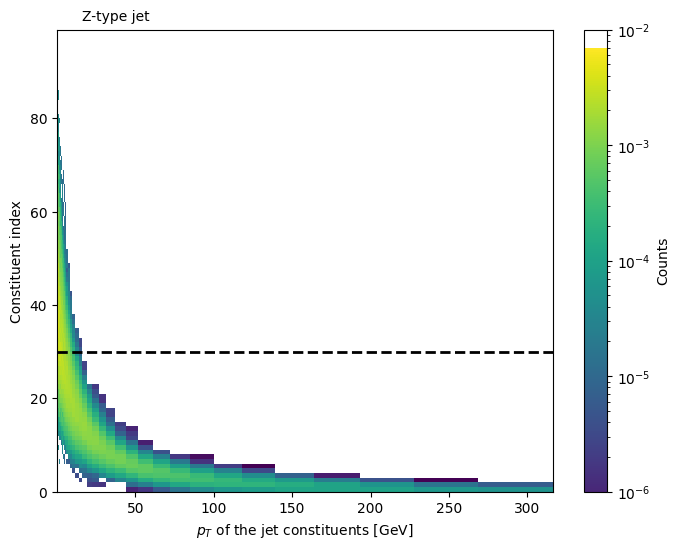

In [23]:
import matplotlib.colors as mplc
fig, ax = plt.subplots(1,1, figsize=(8,6))
labels_to_plot = ['Z']
label_names = ["gluon", "quark", "W", "Z", "top"]
label_idx = {'gluon' : 0, 'quark' : 1, 'W' : 2, 'Z' : 3, 'top' : 4}
label_colors = {'gluon' : 'tab:blue', 'quark' : 'tab:orange', 'W' : 'tab:red', 'Z' : 'tab:green', 'top' : 'tab:purple'}
for label in labels_to_plot :
    jet_type_idx = label_idx[label]
    feat_idx = 5
    data_feature = X_val_full[:,:,feat_idx]
    data_feature = data_feature[y_val[:,jet_type_idx] == 1]
    data_feature1 = np.where(data_feature==0, -1, data_feature)
    indices = np.array([list(np.arange(0,100))]*len(data_feature))

    counts, xedges, yedges, im = ax.hist2d(data_feature.flatten(), indices.flatten(), bins=(np.logspace(-1,2.5,50), np.arange(0,100,1)), density=True, norm=mplc.LogNorm())
    
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Counts")
cbar.ax.set_yscale("log")
cbar.ax.set_ylim(1e-6,1e-2)

ax.axhline(30, linewidth=2, linestyle='--', color='black')
ax.set_xlabel("$p_{T}$ of the jet constituents [GeV]")
ax.set_ylabel("Constituent index")
ax.legend(frameon=False, loc='upper right')
ax.text(0.05, 1.02, "Z-type jet", transform=ax.transAxes)
plt.savefig("particle_pt_Z_jet.png", dpi=200, bbox_inches='tight')

In [40]:
mislabels = np.array([False for val in predict_val[:,0]])
for idx, trueLabel in enumerate(np.argmax(y_val, axis=1)):
    if trueLabel == 0:
        if predict_val[idx,0] < predict_val_TrueTrim[idx,0]:
            mislabels[idx] = True

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


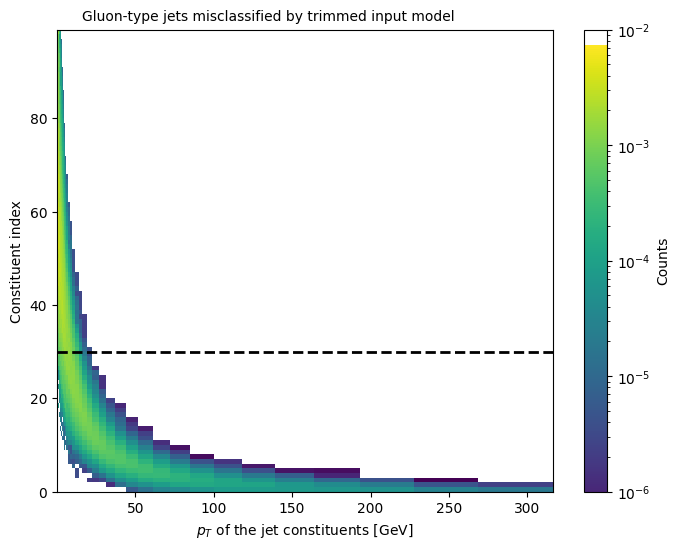

In [39]:
import matplotlib.colors as mplc
fig, ax = plt.subplots(1,1, figsize=(8,6))
labels_to_plot = ['gluon']
label_names = ["gluon", "quark", "W", "Z", "top"]
label_idx = {'gluon' : 0, 'quark' : 1, 'W' : 2, 'Z' : 3, 'top' : 4}
label_colors = {'gluon' : 'tab:blue', 'quark' : 'tab:orange', 'W' : 'tab:red', 'Z' : 'tab:green', 'top' : 'tab:purple'}
for label in labels_to_plot :
    jet_type_idx = label_idx[label]
    feat_idx = 5
    data_feature = X_val_full[:,:,feat_idx]
    data_feature = data_feature[mislabels]
    data_feature1 = np.where(data_feature==0, -1, data_feature)
    indices = np.array([list(np.arange(0,100))]*len(data_feature))

    counts, xedges, yedges, im = ax.hist2d(data_feature.flatten(), indices.flatten(), bins=(np.logspace(-1,2.5,50), np.arange(0,100,1)), density=True, norm=mplc.LogNorm())
    
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Counts")
cbar.ax.set_yscale("log")
cbar.ax.set_ylim(1e-6,1e-2)

ax.axhline(30, linewidth=2, linestyle='--', color='black')
ax.set_xlabel("$p_{T}$ of the jet constituents [GeV]")
ax.set_ylabel("Constituent index")
ax.legend(frameon=False, loc='upper right')
ax.text(0.05, 1.02, "Gluon-type jets misclassified by trimmed input model", transform=ax.transAxes)
plt.savefig("particle_pt_gluon_jet_Mislabel.png", dpi=200, bbox_inches='tight')

In [34]:
predict_val[mislabels,:]

array([[0.7873195 , 0.17720796, 0.01010045, 0.01460449, 0.01076756],
       [0.38729748, 0.3047503 , 0.09411481, 0.07393043, 0.13990696],
       [0.407638  , 0.38134792, 0.10716696, 0.08066879, 0.02317831],
       ...,
       [0.2784371 , 0.19286555, 0.07987262, 0.18583174, 0.26299298],
       [0.9323746 , 0.04810135, 0.00193863, 0.00545773, 0.01212766],
       [0.2631051 , 0.21671832, 0.23744151, 0.16229206, 0.12044299]],
      dtype=float32)

In [42]:
from tensorflow.keras import losses

cce = losses.CategoricalCrossentropy()
print(cce(y_val[mislabels,:], predict_val[mislabels,:]).numpy())
print(cce(y_val[mislabels,:], predict_val_TrueTrim[mislabels,:]).numpy())
print(cce(y_val[y_val[:,0]==1], predict_val[y_val[:,0]==1]).numpy())
print(cce(y_val[y_val[:,0]==1], predict_val_TrueTrim[y_val[:,0]==1]).numpy())
correctlabels = np.array([False for val in predict_val[:,False]])
for idx, trueLabel in enumerate(np.argmax(y_val, axis=1)):
    if trueLabel == 0:
        if np.argmax(predict_val[idx,:]) == 0 and np.argmax(predict_val_TrueTrim[idx,:]) == 0:
            correctlabels[idx] = True
print(cce(y_val[correctlabels,:], predict_val[correctlabels,:]).numpy())
print(cce(y_val[correctlabels,:], predict_val_TrueTrim[correctlabels,:]).numpy())
wronglabels = np.array([False for val in predict_val[:,0]])
for idx, trueLabel in enumerate(np.argmax(y_val, axis=1)):
    if trueLabel == 0:
        if np.argmax(predict_val[idx,:]) != 0 and np.argmax(predict_val_TrueTrim[idx,:]) != 0:
            wronglabels[idx] = True
print(cce(y_val[wronglabels,:], predict_val[wronglabels,:]).numpy())
print(cce(y_val[wronglabels,:], predict_val_TrueTrim[wronglabels,:]).numpy())

1.5279781
1.0917898
1.0449744
1.1697022
0.29558018
0.50681686
1.6326232
1.7085557
